In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [2]:
!pip install --quiet optuna

In [3]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
import optuna
optuna.__version__

'4.0.0'

#### Load dataset 

In [5]:
df = pd.read_csv('train.csv')
df.head()

id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2                             A/T    Blue    Gray   
3  Transmission w/Dual Shift Mode   Black   Black   
4                     7-Speed A/T   Black   Beige   

                                 accident clean_title  price  
0                           None reported         Yes   4200  
1  At least 1 accident or damage reported         Yes   4999  
2                           None reported         Yes  13900  
3                           None reported         Yes  45000  
4                           None reported         Yes  97500

In [6]:
# drop id column because we won't use in our analyse.

df = df.drop(columns=['id'])
df.head()

brand              model  model_year  milage      fuel_type  \
0           MINI      Cooper S Base        2007  213000       Gasoline   
1        Lincoln              LS V8        2002  143250       Gasoline   
2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2                             A/T    Blue    Gray   
3  Transmission w/Dual Shift Mode   Black   Black   
4                     7-Speed A/T   Black   Beige   

                                 accident clean_title  price  
0                           None reported         Yes   4200  
1  At least 1 accident or damage reported         Yes   4999  
2                           None reported         Yes  13900  
3                           None reported         Yes  45000  
4                           None reported         Yes  97500

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 17.3+ MB


In [8]:
df.describe()

model_year         milage         price
count  188533.000000  188533.000000  1.885330e+05
mean     2015.829998   65705.295174  4.387802e+04
std         5.660967   49798.158076  7.881952e+04
min      1974.000000     100.000000  2.000000e+03
25%      2013.000000   24115.000000  1.700000e+04
50%      2017.000000   57785.000000  3.082500e+04
75%      2020.000000   95400.000000  4.990000e+04
max      2024.000000  405000.000000  2.954083e+06

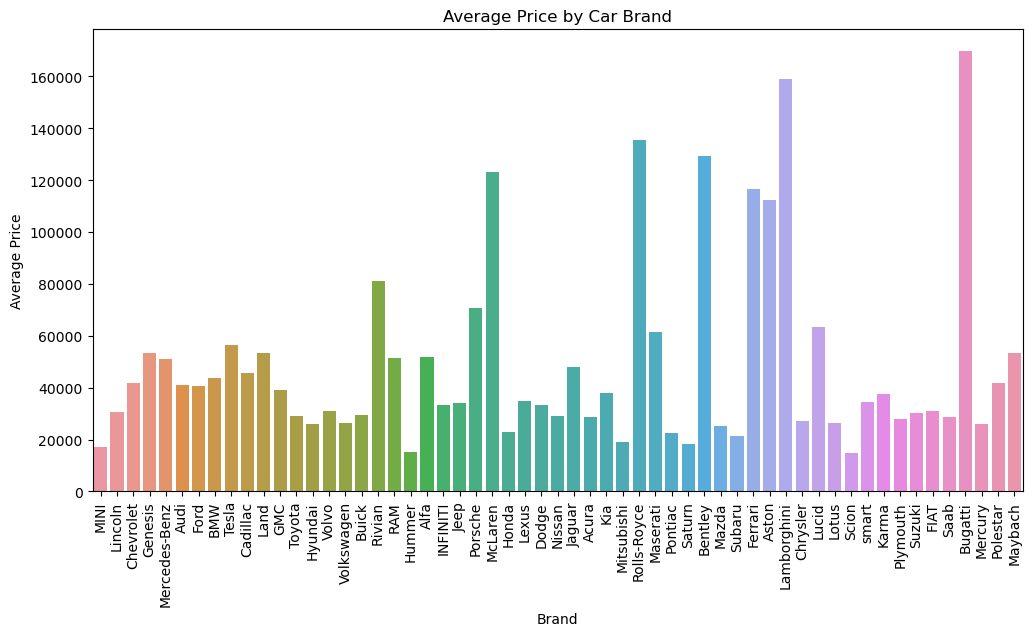

In [9]:
# Average price by brand

plt.figure(figsize=(12, 6))
sns.barplot(x='brand', y='price', data=df, errorbar=None)
plt.title('Average Price by Car Brand')
plt.xlabel('Brand')
plt.ylabel('Average Price')
plt.xticks(rotation=90)  
plt.show()

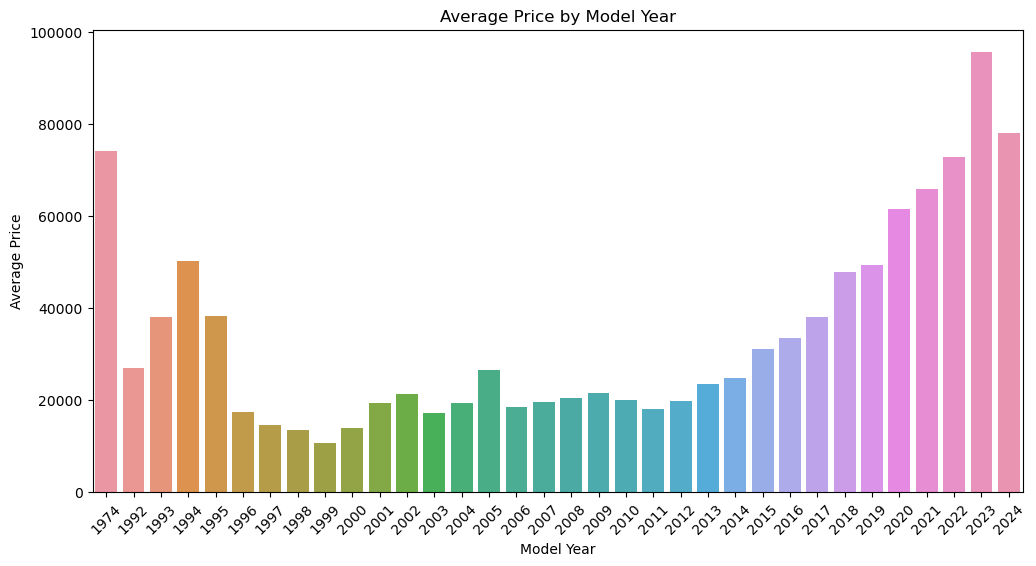

In [10]:
# Average price by brand

plt.figure(figsize=(12, 6))
sns.barplot(x='model_year', y='price', data=df, errorbar=None)
plt.title('Average Price by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Average Price')
plt.xticks(rotation=45)  
plt.show()

As we can see in there are a lot of brands, and price of the cars directly depends of the brand.

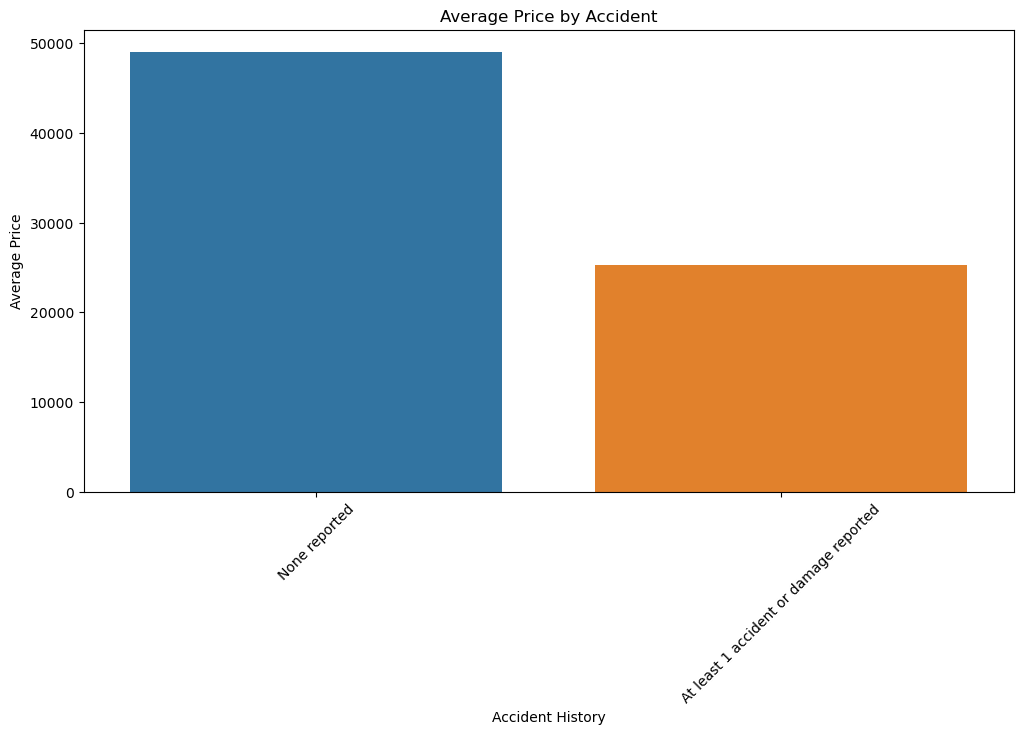

In [11]:
# Average price by accident

plt.figure(figsize=(12, 6))
sns.barplot(x='accident', y='price', data=df, errorbar=None)
plt.title('Average Price by Accident')
plt.xlabel('Accident History')
plt.ylabel('Average Price')
plt.xticks(rotation=45)  
plt.show()

Any accident reduces the price by half

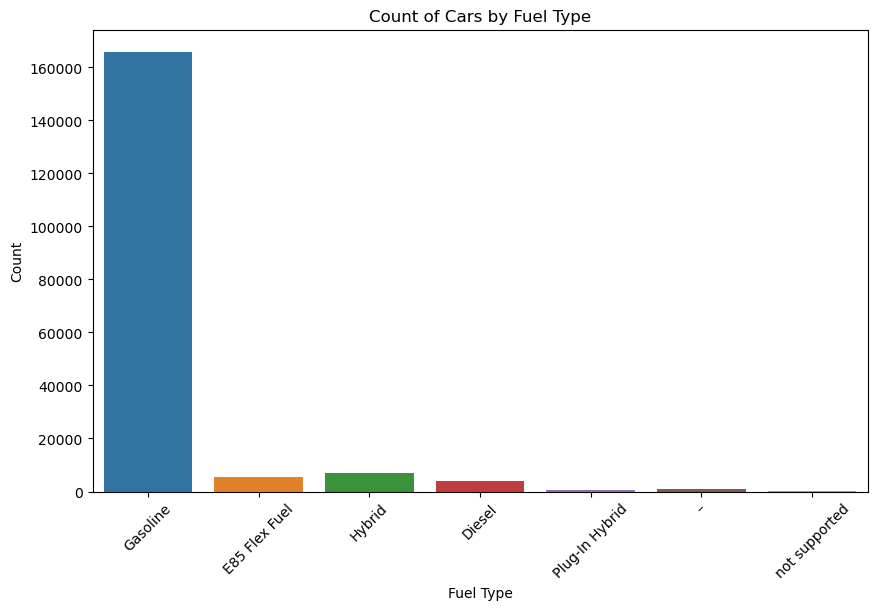

In [12]:
# Counting cars by fuel type

plt.figure(figsize=(10, 6))
sns.countplot(x='fuel_type', data=df)
plt.title('Count of Cars by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Most popular fuel type is obviosly Gasoline 

In [13]:
# counting the number of missing values.

df.isna().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

A lot of values are missing let's make some analyze.

In [14]:
# counting percentage of missing values of each column 

missing_train = df.isna().mean() * 100
missing_values = missing_train[missing_train > 0] 
print(missing_values)

fuel_type       2.696080
accident        1.300568
clean_title    11.360876
dtype: float64


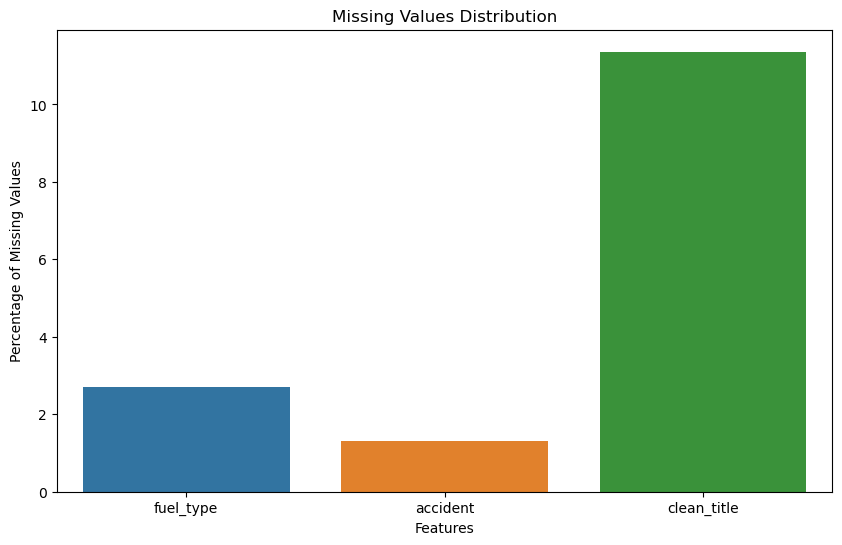

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values)
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Values Distribution');

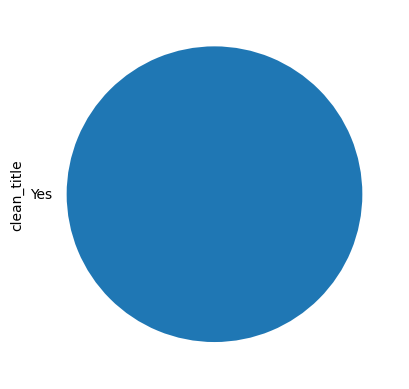

In [16]:
df['clean_title'].value_counts().plot.pie();

In [17]:
df['clean_title'] = df['clean_title'].fillna('No')

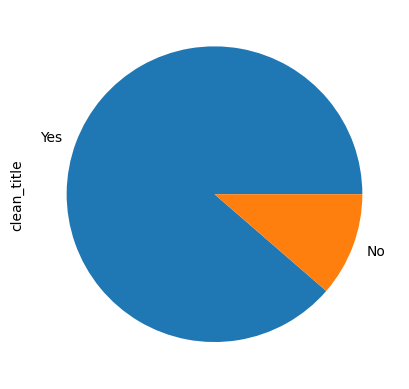

In [18]:
df['clean_title'].value_counts().plot.pie();

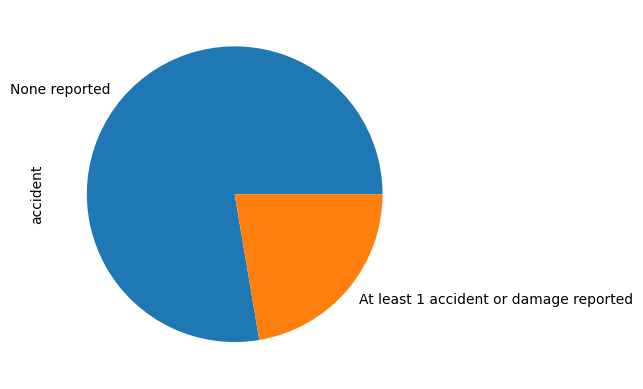

In [19]:
df['accident'].value_counts().plot.pie();

In [20]:
df['fuel_type'].unique()

array(['Gasoline', 'E85 Flex Fuel', nan, 'Hybrid', 'Diesel',
       'Plug-In Hybrid', '–', 'not supported'], dtype=object)

In [21]:
df['fuel_type'].value_counts()

Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: fuel_type, dtype: int64

In [22]:
df['fuel_type'] = df['fuel_type'].replace({'–': 'Unknown', 'not supported': 'Unknown', 'Plug-In Hybrid': 'Unknown' })

In [23]:
df['fuel_type'].value_counts()

Gasoline         165940
Hybrid             6832
E85 Flex Fuel      5406
Diesel             3955
Unknown            1317
Name: fuel_type, dtype: int64

In [24]:

df['accident'] = df['accident'].fillna('Unknown')
df['fuel_type'] = df['fuel_type'].fillna(df['fuel_type'].mode()[0])


As we can see for clean_title column missing values more then 10%, that's we will delete this column. For another columns we will try to fill missing values.

In [25]:
df.isna().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     188533 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      188533 non-null  object
 10  clean_title   188533 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 17.3+ MB


In [27]:
df['engine'].value_counts()[:20]

355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel             3462
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel             2902
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel             2841
2.0L I4 16V GDI DOHC Turbo                               2680
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel            2451
340.0HP 3.0L V6 Cylinder Engine Gasoline Fuel            2436
490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel             2187
455.0HP 6.2L 8 Cylinder Engine Gasoline Fuel             2138
425.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel    2134
300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel    2084
295.0HP 3.5L V6 Cylinder Engine Gasoline Fuel            1917
285.0HP 3.6L V6 Cylinder Engine Gasoline Fuel            1910
302.0HP 3.5L V6 Cylinder Engine Gasoline Fuel            1895
3.5L V6 24V PDI DOHC Twin Turbo                          1842
301.0HP 4.6L 8 Cylinder Engine Gasoline Fuel             1578
5.7L V8 16V MPFI OHV                                     1540
4.0L V8 

In [28]:
df['transmission'].value_counts()

A/T                                                   49904
8-Speed A/T                                           20645
Transmission w/Dual Shift Mode                        19255
6-Speed A/T                                           18044
6-Speed M/T                                           11998
7-Speed A/T                                           11124
Automatic                                             10691
8-Speed Automatic                                      8431
10-Speed A/T                                           8044
9-Speed A/T                                            3866
5-Speed A/T                                            3217
10-Speed Automatic                                     3164
6-Speed Automatic                                      2799
4-Speed A/T                                            2546
5-Speed M/T                                            2409
9-Speed Automatic                                      2325
CVT Transmission                        

In [29]:
# deleting duplicate rows

df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()


0

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188532 entries, 0 to 188531
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188532 non-null  object
 1   model         188532 non-null  object
 2   model_year    188532 non-null  int64 
 3   milage        188532 non-null  int64 
 4   fuel_type     188532 non-null  object
 5   engine        188532 non-null  object
 6   transmission  188532 non-null  object
 7   ext_col       188532 non-null  object
 8   int_col       188532 non-null  object
 9   accident      188532 non-null  object
 10  clean_title   188532 non-null  object
 11  price         188532 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 17.3+ MB


In [54]:
# identify features and target 

y = df['price']
len(y)

188532

In [56]:
X = df.drop('price', axis = 1)
len(X)

188532

In [31]:
df.head()

brand              model  model_year  milage      fuel_type  \
0           MINI      Cooper S Base        2007  213000       Gasoline   
1        Lincoln              LS V8        2002  143250       Gasoline   
2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2                             A/T    Blue    Gray   
3  Transmission w/Dual Shift Mode   Black   Black   
4                     7-Speed A/T   Black   Beige   

                                 accident clean_title  price  
0                           None reported         Yes   4200  
1  At least 1 accident or damage reported         Yes   4999  
2                           None reported         Yes  13900  
3                           None reported         Yes  45000  
4                           None reported         Yes  97500

In [33]:
# cat features

df.info()

cat_features = [0,1,4,7,8,9,10]
text_features = [5,6]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188532 entries, 0 to 188531
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188532 non-null  object
 1   model         188532 non-null  object
 2   model_year    188532 non-null  int64 
 3   milage        188532 non-null  int64 
 4   fuel_type     188532 non-null  object
 5   engine        188532 non-null  object
 6   transmission  188532 non-null  object
 7   ext_col       188532 non-null  object
 8   int_col       188532 non-null  object
 9   accident      188532 non-null  object
 10  clean_title   188532 non-null  object
 11  price         188532 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 17.3+ MB


In [34]:
def objective(trial):
    params = {
        "iterations":300,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0)
    }
    kf = KFold(n_splits=5)
    kf.get_n_splits(X)
    
    rmses = []
    
    for train_index, val_index in kf.split(X):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_val, y_val = X.iloc[val_index], y.iloc[val_index]
        
        # initialize Pool
        train_pool = Pool(X_train,
                  y_train,
                  cat_features= cat_features,
                  text_features= text_features)
        test_pool = Pool(X_val,y_val,
                        cat_features= cat_features,
                        text_features = text_features)
        model = CatBoostRegressor(**params, silent=True)
        model.fit(train_pool, early_stopping_rounds= 5,eval_set=test_pool,verbose = 1)
        predictions = model.predict(test_pool)
        rmse = mean_squared_error(y_val, predictions, squared=False)
        rmses.append(rmse)
    return np.mean(rmses)
        

In [35]:
study = optuna.create_study()
study.optimize(objective, n_trials=50,n_jobs=-1)

trial = study.best_trial

print("MSE: {}".format(trial.value)) 
print("Best hyperparameters: {}".format(trial.params))

[I 2024-09-27 14:18:51,113] A new study created in memory with name: no-name-97ab56fe-51da-40c0-94c9-2144b21e7b80


0:	learn: 79100.6581764	test: 77457.3434829	best: 77457.3434829 (0)	total: 1.7s	remaining: 8m 29s
0:	learn: 78938.4418272	test: 77285.9457299	best: 77285.9457299 (0)	total: 1.32s	remaining: 6m 34s
1:	learn: 79056.9549810	test: 77411.5142683	best: 77411.5142683 (1)	total: 2.61s	remaining: 6m 28s
2:	learn: 79013.1978001	test: 77365.8017099	best: 77365.8017099 (2)	total: 2.93s	remaining: 4m 50s
1:	learn: 78734.4633897	test: 77076.3669835	best: 77076.3669835 (1)	total: 2.96s	remaining: 7m 20s
3:	learn: 78970.2534666	test: 77321.4279663	best: 77321.4279663 (3)	total: 6.37s	remaining: 7m 51s
0:	learn: 79131.6917808	test: 77490.3230949	best: 77490.3230949 (0)	total: 6.71s	remaining: 33m 25s
0:	learn: 79099.7846602	test: 77458.4498395	best: 77458.4498395 (0)	total: 5.59s	remaining: 27m 52s
2:	learn: 78547.3150375	test: 76878.8723605	best: 76878.8723605 (2)	total: 7.05s	remaining: 11m 38s
0:	learn: 78698.8633289	test: 77047.6869614	best: 77047.6869614 (0)	total: 5.78s	remaining: 28m 49s
4:	lear

[I 2024-09-27 14:25:00,080] Trial 18 finished with value: 73104.69355126788 and parameters: {'learning_rate': 0.0799066485584904, 'depth': 3, 'subsample': 0.129776892044415}. Best is trial 18 with value: 73104.69355126788.


120:	learn: 72012.0890304	test: 75723.3630116	best: 75723.3630116 (120)	total: 1m 27s	remaining: 2m 9s
223:	learn: 76770.2840900	test: 68509.8767941	best: 68509.8767941 (223)	total: 1m 13s	remaining: 25.1s
91:	learn: 75926.4581864	test: 67645.2329126	best: 67645.2329126 (91)	total: 34.4s	remaining: 1m 17s
90:	learn: 72365.4052817	test: 75067.3599764	best: 75067.3599764 (90)	total: 58.7s	remaining: 2m 14s
5:	learn: 79248.6371825	test: 71199.7921731	best: 71199.7921731 (5)	total: 3.28s	remaining: 2m 40s
55:	learn: 78446.7450209	test: 76814.7771303	best: 76814.7771303 (55)	total: 6m 3s	remaining: 26m 25s
87:	learn: 72138.8199293	test: 75766.8977153	best: 75766.8977153 (87)	total: 1m 21s	remaining: 3m 16s
148:	learn: 75218.0620947	test: 67065.4144257	best: 67065.4144257 (148)	total: 51.7s	remaining: 52.4s
0:	learn: 78235.4544830	test: 80883.4595859	best: 80883.4595859 (0)	total: 682ms	remaining: 3m 24s
224:	learn: 76765.3590253	test: 68504.8291457	best: 68504.8291457 (224)	total: 1m 14s	re

[I 2024-09-27 14:25:40,755] Trial 15 finished with value: 73067.2500462844 and parameters: {'learning_rate': 0.07519200901117588, 'depth': 3, 'subsample': 0.7963266019804849}. Best is trial 15 with value: 73067.2500462844.


255:	learn: 74926.8459035	test: 66822.4248473	best: 66822.4248473 (255)	total: 1m 29s	remaining: 15.5s
58:	learn: 76130.4723786	test: 78893.9977267	best: 78893.9977267 (58)	total: 40.2s	remaining: 2m 44s
3:	learn: 77817.6206728	test: 81937.0728656	best: 81937.0728656 (3)	total: 6.47s	remaining: 7m 59s
196:	learn: 75251.1263476	test: 67081.3012043	best: 67081.3012043 (196)	total: 1m 13s	remaining: 38.7s
60:	learn: 78388.3065928	test: 76757.0419847	best: 76757.0419847 (60)	total: 6m 44s	remaining: 26m 25s
14:	learn: 76954.4209076	test: 68822.5414350	best: 68822.5414350 (14)	total: 13.6s	remaining: 4m 18s
79:	learn: 75517.8696028	test: 67276.1628706	best: 67276.1628706 (79)	total: 43.5s	remaining: 1m 59s
131:	learn: 71789.6015592	test: 75670.2436672	best: 75670.2436672 (131)	total: 2m 1s	remaining: 2m 34s
4:	learn: 78096.9269400	test: 80575.1856780	best: 80575.1856780 (4)	total: 2.91s	remaining: 2m 51s
8:	learn: 77353.3546681	test: 69362.2286306	best: 69362.2286306 (8)	total: 12s	remainin

[I 2024-09-27 14:27:31,918] Trial 0 finished with value: 74629.7433568857 and parameters: {'learning_rate': 0.007419365009394435, 'depth': 1, 'subsample': 0.4250512864398838}. Best is trial 15 with value: 73067.2500462844.


108:	learn: 73660.1327938	test: 66546.4491943	best: 66546.4491943 (108)	total: 2m 2s	remaining: 3m 34s
261:	learn: 73667.1016023	test: 72349.2807890	best: 72349.2807890 (261)	total: 8m 20s	remaining: 1m 12s
1:	learn: 77610.0703169	test: 80116.6665093	best: 80116.6665093 (1)	total: 2.27s	remaining: 5m 38s
214:	learn: 73875.9174446	test: 76865.6946457	best: 76865.6946457 (214)	total: 2m 32s	remaining: 1m
293:	learn: 75548.4212901	test: 73722.1752893	best: 73722.1752893 (293)	total: 1m 40s	remaining: 2.04s
42:	learn: 71729.9377659	test: 75867.2745577	best: 75867.2745577 (42)	total: 1m 29s	remaining: 8m 56s
155:	learn: 73399.5255021	test: 75859.2872950	best: 75859.2872950 (155)	total: 1m 3s	remaining: 58.8s
216:	learn: 73013.9984613	test: 75382.4285929	best: 75382.4285929 (216)	total: 1m 23s	remaining: 32.1s
19:	learn: 74012.6724124	test: 77275.8356605	best: 77275.8356605 (19)	total: 37.3s	remaining: 8m 42s
294:	learn: 75544.6047344	test: 73717.9749710	best: 73717.9749710 (294)	total: 1m 4

[I 2024-09-27 14:28:08,935] Trial 17 finished with value: 73277.83635830648 and parameters: {'learning_rate': 0.047206596881689426, 'depth': 1, 'subsample': 0.5860638494055893}. Best is trial 15 with value: 73067.2500462844.


54:	learn: 73970.6419820	test: 76508.5596353	best: 76508.5596353 (54)	total: 33.5s	remaining: 2m 29s
271:	learn: 73459.2391433	test: 76494.7777862	best: 76494.7777862 (271)	total: 3m 6s	remaining: 19.1s
139:	learn: 73390.6700804	test: 66515.1766108	best: 66511.4182630 (134)	total: 2m 36s	remaining: 2m 59s
20:	learn: 74062.0157626	test: 76686.1192930	best: 76686.1192930 (20)	total: 25s	remaining: 5m 32s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 66511.41826
bestIteration = 134

Shrink model to first 135 iterations.
24:	learn: 77478.4526838	test: 75768.4773769	best: 75768.4773769 (24)	total: 28.4s	remaining: 5m 11s
38:	learn: 73278.2479314	test: 75923.7718617	best: 75923.7718617 (38)	total: 36.6s	remaining: 4m 4s
39:	learn: 72556.3842795	test: 76208.5130005	best: 76208.5130005 (39)	total: 1m 10s	remaining: 7m 41s
52:	learn: 76527.6491483	test: 80699.1052765	best: 80699.1052765 (52)	total: 20s	remaining: 1m 33s
238:	learn: 73137.8410402	test: 75532.4120924	best: 7553

[I 2024-09-27 14:28:37,329] Trial 13 finished with value: 73405.12260036397 and parameters: {'learning_rate': 0.03407099846511696, 'depth': 1, 'subsample': 0.7458933089587838}. Best is trial 15 with value: 73067.2500462844.


122:	learn: 75433.6301769	test: 79656.3690954	best: 79656.3690954 (122)	total: 47s	remaining: 1m 7s
76:	learn: 73075.8012002	test: 72000.9891966	best: 72000.9891966 (76)	total: 9m 37s	remaining: 27m 52s
70:	learn: 71055.6414568	test: 75677.1396000	best: 75677.1396000 (70)	total: 2m 32s	remaining: 8m 11s
80:	learn: 78160.1150070	test: 76530.5418656	best: 76530.5418656 (80)	total: 9m 40s	remaining: 26m 8s
160:	learn: 73879.7246062	test: 66628.5579776	best: 66628.5579776 (160)	total: 2m 35s	remaining: 2m 14s
105:	learn: 73256.9623968	test: 75726.4982465	best: 75726.4982465 (105)	total: 1m 1s	remaining: 1m 52s
44:	learn: 72900.6519723	test: 75559.0637592	best: 75559.0637592 (44)	total: 53.2s	remaining: 5m 1s
121:	learn: 74618.0987605	test: 79043.1775291	best: 79043.1775291 (121)	total: 3m 2s	remaining: 4m 25s
71:	learn: 72657.4207535	test: 75348.1159785	best: 75348.1159785 (71)	total: 1m 4s	remaining: 3m 23s
48:	learn: 76401.3617305	test: 74647.4453949	best: 74647.4453949 (48)	total: 56.4s

[I 2024-09-27 14:29:58,250] Trial 19 finished with value: 73064.0654595816 and parameters: {'learning_rate': 0.04781261989010337, 'depth': 5, 'subsample': 0.9738737850442476}. Best is trial 19 with value: 73064.0654595816.


151:	learn: 75311.3479300	test: 79659.4165808	best: 79659.4165808 (151)	total: 3m 58s	remaining: 3m 52s
18:	learn: 77094.4459681	test: 81295.7167674	best: 81295.7167674 (18)	total: 44.9s	remaining: 11m 3s
163:	learn: 71787.1511901	test: 74990.9451850	best: 74990.9451850 (163)	total: 2m 23s	remaining: 1m 59s
113:	learn: 74778.3069092	test: 72998.2466166	best: 72998.2466166 (113)	total: 2m 16s	remaining: 3m 41s
250:	learn: 72644.2081429	test: 75173.0636266	best: 75173.0636266 (250)	total: 2m 18s	remaining: 27s
69:	learn: 71965.3486944	test: 75108.8984463	best: 75108.8984463 (69)	total: 1m 36s	remaining: 5m 16s
93:	learn: 77467.0551981	test: 69326.9576427	best: 69326.9576427 (93)	total: 1m 17s	remaining: 2m 50s
41:	learn: 74710.9858395	test: 73253.4557567	best: 73253.4557567 (41)	total: 1m 40s	remaining: 10m 17s
88:	learn: 78072.0696829	test: 76444.8434050	best: 76444.8434050 (88)	total: 11m	remaining: 26m 6s
41:	learn: 76347.2779020	test: 74672.9879419	best: 74672.9879419 (41)	total: 1m 

[I 2024-09-27 14:30:08,688] Trial 16 finished with value: 73065.75096719856 and parameters: {'learning_rate': 0.04651566916225922, 'depth': 4, 'subsample': 0.4962268812469143}. Best is trial 19 with value: 73064.0654595816.


157:	learn: 75235.8469722	test: 79592.0512802	best: 79592.0512802 (157)	total: 4m 8s	remaining: 3m 43s
51:	learn: 72868.2341629	test: 75589.3272900	best: 75589.3272900 (51)	total: 1m 4s	remaining: 5m 7s
10:	learn: 77913.6830135	test: 80574.9774225	best: 80574.9774225 (10)	total: 4.38s	remaining: 1m 55s
89:	learn: 78061.5633146	test: 76434.2172479	best: 76434.2172479 (89)	total: 11m 10s	remaining: 26m 5s
104:	learn: 77271.6216735	test: 69119.4559793	best: 69119.4559793 (104)	total: 1m 27s	remaining: 2m 42s
9:	learn: 76855.5622878	test: 69033.4255569	best: 69033.4255569 (9)	total: 23.9s	remaining: 11m 32s
269:	learn: 72586.5239763	test: 75139.1208613	best: 75139.1208613 (269)	total: 2m 27s	remaining: 16.4s
110:	learn: 71204.4061355	test: 75644.2202620	best: 75644.0976260 (109)	total: 3m 9s	remaining: 5m 22s
122:	learn: 74632.6026598	test: 72843.5288394	best: 72843.5288394 (122)	total: 2m 26s	remaining: 3m 31s
11:	learn: 77881.7393361	test: 80544.3580566	best: 80544.3580566 (11)	total: 4.

[I 2024-09-27 14:30:25,174] Trial 2 finished with value: 73173.1727719792 and parameters: {'learning_rate': 0.03122531167082713, 'depth': 2, 'subsample': 0.474922658195337}. Best is trial 19 with value: 73064.0654595816.


187:	learn: 73679.2564894	test: 78235.7126537	best: 78235.7126537 (187)	total: 4m 48s	remaining: 2m 51s
66:	learn: 72570.6871320	test: 75399.9395805	best: 75399.9395805 (66)	total: 1m 20s	remaining: 4m 40s
22:	learn: 74493.0724371	test: 72521.7665073	best: 72521.7665073 (22)	total: 15.3s	remaining: 3m 3s
124:	learn: 76956.8979080	test: 68793.0328016	best: 68793.0328016 (124)	total: 1m 43s	remaining: 2m 24s
92:	learn: 71596.8118490	test: 75004.3394425	best: 75003.5430613 (90)	total: 2m 2s	remaining: 4m 32s
30:	learn: 76604.3743238	test: 80857.3574847	best: 80857.3574847 (30)	total: 1m 11s	remaining: 10m 19s
52:	learn: 76825.0891183	test: 79534.4808934	best: 79534.4808934 (52)	total: 20.3s	remaining: 1m 34s
138:	learn: 74407.8088808	test: 72609.2882705	best: 72609.2882705 (138)	total: 2m 42s	remaining: 3m 8s
86:	learn: 76242.7834702	test: 74685.4321693	best: 74685.4321693 (86)	total: 11m 28s	remaining: 28m 4s
4:	learn: 78953.8439171	test: 77302.6113938	best: 77302.6113938 (4)	total: 6.36

[I 2024-09-27 14:31:25,023] Trial 5 finished with value: 73015.11955186093 and parameters: {'learning_rate': 0.053864547387215196, 'depth': 6, 'subsample': 0.989559188038344}. Best is trial 5 with value: 73015.11955186093.


122:	learn: 71902.2106173	test: 75059.4179554	best: 75058.2961329 (121)	total: 2m 19s	remaining: 3m 20s
194:	learn: 73891.6906298	test: 72098.6215896	best: 72098.6215896 (194)	total: 3m 41s	remaining: 1m 59s
33:	learn: 78792.5309455	test: 77141.3164123	best: 77141.3164123 (33)	total: 48s	remaining: 6m 15s
197:	learn: 76182.6719877	test: 68025.3886049	best: 68025.3886049 (197)	total: 2m 42s	remaining: 1m 23s
199:	learn: 75069.9282565	test: 77853.2842661	best: 77853.2842661 (199)	total: 1m 18s	remaining: 39s
57:	learn: 75662.8992421	test: 80027.2302824	best: 80027.2302824 (57)	total: 2m 11s	remaining: 9m 6s
3:	learn: 79065.2245159	test: 71108.5537404	best: 71108.5537404 (3)	total: 7.36s	remaining: 9m 4s
42:	learn: 73903.0782597	test: 66853.5787117	best: 66853.5787117 (42)	total: 1m 40s	remaining: 9m 58s
54:	learn: 77399.3878777	test: 75692.4727005	best: 75692.4727005 (54)	total: 1m 5s	remaining: 4m 50s
200:	learn: 75063.6254220	test: 77846.8979414	best: 77846.8979414 (200)	total: 1m 18s	

[I 2024-09-27 14:32:34,025] Trial 8 finished with value: 73036.15901326665 and parameters: {'learning_rate': 0.04128607353628697, 'depth': 5, 'subsample': 0.6949127700827761}. Best is trial 5 with value: 73015.11955186093.


142:	learn: 76948.8770542	test: 75201.2765862	best: 75201.2765862 (142)	total: 55.5s	remaining: 1m
75:	learn: 73245.1061290	test: 66660.4140990	best: 66660.4140990 (75)	total: 2m 47s	remaining: 8m 12s
39:	learn: 79206.2320629	test: 71149.2006795	best: 71149.2006795 (39)	total: 16.1s	remaining: 1m 44s
113:	learn: 76177.8890468	test: 74420.4453995	best: 74420.4453995 (113)	total: 2m 12s	remaining: 3m 36s
88:	learn: 74822.1334635	test: 79298.7066256	best: 79298.7066256 (88)	total: 3m 19s	remaining: 7m 52s
40:	learn: 79183.0903266	test: 71124.0499209	best: 71124.0499209 (40)	total: 16.5s	remaining: 1m 43s
82:	learn: 78327.5891877	test: 76663.2000004	best: 76663.2000004 (82)	total: 1m 55s	remaining: 5m
143:	learn: 76939.2479627	test: 75191.0926323	best: 75191.0926323 (143)	total: 55.9s	remaining: 1m
254:	learn: 73559.8633580	test: 71831.7640737	best: 71831.7640737 (254)	total: 4m 48s	remaining: 50.9s
246:	learn: 74315.3484669	test: 78784.6986279	best: 78784.6986279 (246)	total: 6m 31s	remai

[I 2024-09-27 14:36:00,170] Trial 25 finished with value: 73128.90176096748 and parameters: {'learning_rate': 0.09863733522747538, 'depth': 2, 'subsample': 0.6709260248556674}. Best is trial 5 with value: 73015.11955186093.


181:	learn: 73197.7625606	test: 77988.6812703	best: 77988.6812703 (181)	total: 6m 44s	remaining: 4m 22s
11:	learn: 77999.6858454	test: 80657.6532036	best: 80657.6532036 (11)	total: 5.02s	remaining: 2m
32:	learn: 73181.3825324	test: 76121.8356205	best: 76121.8356205 (32)	total: 57.8s	remaining: 7m 47s
247:	learn: 73776.3438234	test: 76340.1852507	best: 76340.1852507 (247)	total: 3m 16s	remaining: 41.2s
90:	learn: 75495.1170418	test: 78460.5703868	best: 78460.5703868 (90)	total: 2m 26s	remaining: 5m 36s
272:	learn: 72881.2951111	test: 71637.5519772	best: 71637.5519772 (272)	total: 7m 8s	remaining: 42.4s
222:	learn: 74972.8535638	test: 77565.8440055	best: 77565.8440055 (222)	total: 1m 28s	remaining: 30.6s
119:	learn: 73428.0664231	test: 77890.4532825	best: 77890.4532825 (119)	total: 2m 22s	remaining: 3m 33s
12:	learn: 77977.1756485	test: 80636.1439270	best: 80636.1439270 (12)	total: 5.51s	remaining: 2m 1s
232:	learn: 77151.8275322	test: 75454.5424270	best: 75454.5424270 (232)	total: 5m 20

[I 2024-09-27 14:36:34,700] Trial 21 finished with value: 75047.29985474618 and parameters: {'learning_rate': 0.005771911852645625, 'depth': 1, 'subsample': 0.2526374842286649}. Best is trial 5 with value: 73015.11955186093.


254:	learn: 77007.9429650	test: 75306.7281652	best: 75306.7281652 (254)	total: 5m 53s	remaining: 1m 2s
297:	learn: 73503.4685072	test: 76044.2831340	best: 76044.2831340 (297)	total: 3m 50s	remaining: 1.54s
145:	learn: 73089.6291785	test: 77617.6981527	best: 77617.6981527 (145)	total: 2m 56s	remaining: 3m 5s
110:	learn: 75090.7560676	test: 78115.2270357	best: 78115.2270357 (110)	total: 3m	remaining: 5m 7s
92:	learn: 76599.0634510	test: 79318.8107969	best: 79318.8107969 (92)	total: 38.5s	remaining: 1m 25s
195:	learn: 73033.6834112	test: 77869.6981623	best: 77869.6981623 (195)	total: 7m 19s	remaining: 3m 53s
81:	learn: 76618.9104711	test: 79443.1719710	best: 79443.1719710 (81)	total: 2m 18s	remaining: 6m 8s
298:	learn: 73499.1941484	test: 76039.7969038	best: 76039.7969038 (298)	total: 3m 50s	remaining: 772ms
93:	learn: 76586.1618972	test: 79306.5961028	best: 79306.5961028 (93)	total: 38.9s	remaining: 1m 25s
116:	learn: 76028.9061370	test: 74415.5475892	best: 74415.5475892 (116)	total: 3m 

[I 2024-09-27 14:36:37,641] Trial 12 finished with value: 73925.81798552524 and parameters: {'learning_rate': 0.006334886614817637, 'depth': 3, 'subsample': 0.3240389800182001}. Best is trial 5 with value: 73015.11955186093.


97:	learn: 76534.0394331	test: 79257.0008950	best: 79257.0008950 (97)	total: 40.9s	remaining: 1m 24s
117:	learn: 76010.9710606	test: 74398.1790003	best: 74398.1790003 (117)	total: 3m 52s	remaining: 5m 59s
128:	learn: 77652.0648073	test: 76032.8232874	best: 76032.8232874 (128)	total: 17m 40s	remaining: 23m 25s
120:	learn: 75512.6240174	test: 74000.5654748	best: 74000.5654748 (120)	total: 17m 41s	remaining: 26m 10s
123:	learn: 72443.2045451	test: 71654.5467738	best: 71654.5467738 (123)	total: 17m 40s	remaining: 25m 5s
51:	learn: 72356.4467045	test: 75488.3838957	best: 75488.3838957 (51)	total: 1m 36s	remaining: 7m 40s
99:	learn: 70666.4968405	test: 74928.4933815	best: 74927.0425106 (98)	total: 3m 40s	remaining: 7m 21s
12:	learn: 78953.8846659	test: 77309.5158796	best: 77309.5158796 (12)	total: 28.9s	remaining: 10m 38s
293:	learn: 72789.9554876	test: 71591.3439817	best: 71591.3439817 (293)	total: 7m 47s	remaining: 9.55s
98:	learn: 76521.1468636	test: 79244.8272804	best: 79244.8272804 (98)

[I 2024-09-27 14:37:38,710] Trial 10 finished with value: 73001.22523109664 and parameters: {'learning_rate': 0.05302207944721311, 'depth': 9, 'subsample': 0.6777264764447457}. Best is trial 10 with value: 73001.22523109664.


199:	learn: 72564.1618934	test: 77187.0282561	best: 77187.0282561 (199)	total: 3m 58s	remaining: 1m 59s
115:	learn: 76073.5202767	test: 78965.9082543	best: 78965.9082543 (115)	total: 3m 21s	remaining: 5m 19s
125:	learn: 75419.9930832	test: 73914.8679790	best: 73914.8679790 (125)	total: 18m 41s	remaining: 25m 48s
20:	learn: 76289.0327138	test: 80534.3993357	best: 80534.3993357 (20)	total: 36.7s	remaining: 8m 7s
244:	learn: 75288.4297137	test: 78064.6567468	best: 78064.6567468 (244)	total: 1m 39s	remaining: 22.3s
39:	learn: 78577.5033917	test: 76926.1622416	best: 76926.1622416 (39)	total: 1m 27s	remaining: 9m 27s
25:	learn: 78829.4313030	test: 77182.3639265	best: 77182.3639265 (25)	total: 55.1s	remaining: 9m 40s
69:	learn: 76621.1857725	test: 75049.8868871	best: 75049.8868871 (69)	total: 12m 29s	remaining: 41m 2s
84:	learn: 71752.2146360	test: 75103.8876750	best: 75103.8876750 (84)	total: 2m 35s	remaining: 6m 34s
128:	learn: 72369.0757671	test: 71626.5168719	best: 71626.5168719 (128)	tot

[I 2024-09-27 14:41:33,139] Trial 4 finished with value: 73000.39872236879 and parameters: {'learning_rate': 0.03795372653793541, 'depth': 8, 'subsample': 0.27364155244816246}. Best is trial 4 with value: 73000.39872236879.


251:	learn: 73334.6728357	test: 77803.1671671	best: 77803.1671671 (251)	total: 5m 15s	remaining: 1m
7:	learn: 77887.2699817	test: 80581.4747050	best: 80581.4747050 (7)	total: 22.4s	remaining: 13m 36s
145:	learn: 77318.9220381	test: 75661.6939109	best: 75661.6939109 (145)	total: 5m 20s	remaining: 5m 37s
258:	learn: 74289.7414278	test: 72767.5348302	best: 72767.5348302 (258)	total: 8m 44s	remaining: 1m 22s
276:	learn: 73111.4097925	test: 76527.3352142	best: 76527.3352142 (276)	total: 7m 57s	remaining: 39.7s
136:	learn: 76657.5058545	test: 80859.5321602	best: 80859.5321602 (136)	total: 3m 35s	remaining: 4m 16s
144:	learn: 75095.6742653	test: 73625.3584659	best: 73625.3584659 (144)	total: 22m 34s	remaining: 24m 7s
240:	learn: 74605.5255185	test: 77708.7093516	best: 77708.7093516 (240)	total: 7m 13s	remaining: 1m 46s
81:	learn: 74378.7476903	test: 77422.6246548	best: 77422.6246548 (81)	total: 1m 53s	remaining: 5m
152:	learn: 72454.4961960	test: 77262.0282854	best: 77262.0282854 (152)	total:

[I 2024-09-27 14:42:49,072] Trial 28 finished with value: 75502.82284163659 and parameters: {'learning_rate': 0.004001711605633075, 'depth': 1, 'subsample': 0.10119968726729389}. Best is trial 4 with value: 73000.39872236879.


162:	learn: 77125.2079950	test: 75474.7269562	best: 75474.7269562 (162)	total: 5m 58s	remaining: 5m 1s
182:	learn: 76290.9505947	test: 80519.9895552	best: 80519.9895552 (182)	total: 4m 50s	remaining: 3m 6s
24:	learn: 78814.4934137	test: 77172.3789240	best: 77172.3789240 (24)	total: 1m 2s	remaining: 11m 29s
161:	learn: 77331.5342895	test: 75721.5147423	best: 75721.5147423 (161)	total: 23m 51s	remaining: 20m 19s
136:	learn: 73413.2077747	test: 76638.1860947	best: 76638.1860947 (136)	total: 3m 9s	remaining: 3m 44s
110:	learn: 77873.5151062	test: 76231.6161837	best: 76231.6161837 (110)	total: 4m 59s	remaining: 8m 29s
8:	learn: 79989.6113050	test: 72026.2619998	best: 72026.2619998 (8)	total: 17.5s	remaining: 9m 24s
291:	learn: 74037.8638280	test: 72557.9586055	best: 72557.9586055 (291)	total: 10m	remaining: 16.5s
177:	learn: 77002.6368241	test: 75349.7718070	best: 75349.7718070 (177)	total: 6m 36s	remaining: 4m 31s
61:	learn: 72544.2861689	test: 77474.7607106	best: 77474.7607106 (61)	total:

[I 2024-09-27 15:11:10,633] Trial 26 finished with value: 74057.47251012645 and parameters: {'learning_rate': 0.004669783982126695, 'depth': 5, 'subsample': 0.3963617433035035}. Best is trial 4 with value: 73000.39872236879.


102:	learn: 77076.3758012	test: 79856.7348558	best: 79856.7348558 (102)	total: 5m 11s	remaining: 9m 55s
228:	learn: 75104.7056111	test: 67518.9091386	best: 67518.9091386 (228)	total: 12m 28s	remaining: 3m 52s
48:	learn: 75460.1111366	test: 67820.2308519	best: 67820.2308519 (48)	total: 2m 55s	remaining: 14m 59s
141:	learn: 76282.4135171	test: 80573.9743260	best: 80573.9743260 (141)	total: 9m 27s	remaining: 10m 31s
168:	learn: 75498.8417036	test: 78127.9273873	best: 78127.9273873 (168)	total: 9m 30s	remaining: 7m 22s
214:	learn: 73790.0178665	test: 76583.7973607	best: 76583.7973607 (214)	total: 11m 46s	remaining: 4m 39s
142:	learn: 78991.5565011	test: 70992.2120721	best: 70992.2120721 (142)	total: 6m 56s	remaining: 7m 37s
251:	learn: 72731.6826896	test: 75459.5627871	best: 75459.5627871 (251)	total: 9m 44s	remaining: 1m 51s
5:	learn: 78188.3175406	test: 80843.9334065	best: 80843.9334065 (5)	total: 22.1s	remaining: 18m 5s
108:	learn: 75166.0928972	test: 78227.7391131	best: 78227.7391131 (

[I 2024-09-27 15:13:07,319] Trial 22 finished with value: 73317.08257065069 and parameters: {'learning_rate': 0.00956838874195057, 'depth': 5, 'subsample': 0.5383435723535667}. Best is trial 4 with value: 73000.39872236879.


141:	learn: 76683.1113855	test: 79512.9071579	best: 79512.9071579 (141)	total: 7m 5s	remaining: 7m 53s
165:	learn: 76167.6296669	test: 79074.2714982	best: 79074.2714982 (165)	total: 8m 22s	remaining: 6m 45s
35:	learn: 77738.2756806	test: 80439.5428098	best: 80439.5428098 (35)	total: 2m 16s	remaining: 16m 39s
170:	learn: 76001.7646967	test: 80328.5863901	best: 80328.5863901 (170)	total: 11m 21s	remaining: 8m 33s
249:	learn: 73483.0859656	test: 76316.6022491	best: 76316.6022491 (249)	total: 13m 40s	remaining: 2m 44s
201:	learn: 75140.2202943	test: 77801.9887230	best: 77801.9887230 (201)	total: 11m 24s	remaining: 5m 32s
165:	learn: 74759.3939506	test: 67129.9455497	best: 67129.9455497 (165)	total: 8m 24s	remaining: 6m 46s
30:	learn: 76034.2645322	test: 74419.0152472	best: 74419.0152472 (30)	total: 1m 42s	remaining: 14m 48s
137:	learn: 74648.9083576	test: 77805.7520346	best: 77805.7520346 (137)	total: 9m 6s	remaining: 10m 41s
182:	learn: 78680.3113774	test: 70673.2960501	best: 70673.296050

[I 2024-09-27 15:15:53,957] Trial 7 finished with value: 73946.34047366514 and parameters: {'learning_rate': 0.00448231268437175, 'depth': 7, 'subsample': 0.681291648535983}. Best is trial 4 with value: 73000.39872236879.


255:	learn: 74630.4245219	test: 77327.3844061	best: 77327.3844061 (255)	total: 14m 13s	remaining: 2m 26s
79:	learn: 77136.6206519	test: 79906.3163690	best: 79906.3163690 (79)	total: 5m 4s	remaining: 13m 57s
212:	learn: 74110.6105001	test: 72786.1449854	best: 72786.1449854 (212)	total: 50m 44s	remaining: 20m 43s
168:	learn: 76262.1817150	test: 80554.3366868	best: 80554.3366868 (168)	total: 11m 29s	remaining: 8m 54s
253:	learn: 75372.3110791	test: 79776.3908995	best: 79776.3908995 (253)	total: 18m 52s	remaining: 3m 25s
44:	learn: 73287.5679382	test: 78111.8116711	best: 78111.8116711 (44)	total: 12m 49s	remaining: 1h 12m 41s
213:	learn: 75616.8443862	test: 79991.3796985	best: 79991.3796985 (213)	total: 14m 11s	remaining: 5m 42s
194:	learn: 76199.6486262	test: 79095.7407868	best: 79095.7407868 (194)	total: 9m 56s	remaining: 5m 21s
7:	learn: 77947.0646312	test: 80436.2918279	best: 80436.2918279 (7)	total: 28.9s	remaining: 17m 33s
180:	learn: 74031.9527292	test: 77313.9144775	best: 77313.914

[I 2024-09-27 15:18:37,064] Trial 9 finished with value: 74933.63687464935 and parameters: {'learning_rate': 0.002555500883279821, 'depth': 7, 'subsample': 0.8449392529525249}. Best is trial 4 with value: 73000.39872236879.


243:	learn: 75803.9485205	test: 78760.9487277	best: 78760.9487277 (243)	total: 12m 34s	remaining: 2m 53s
119:	learn: 76643.2068051	test: 79479.5949011	best: 79479.5949011 (119)	total: 7m 43s	remaining: 11m 35s
271:	learn: 75219.3931460	test: 78274.5026663	best: 78274.5026663 (271)	total: 13m 50s	remaining: 1m 25s
172:	learn: 73327.4673329	test: 66655.5180275	best: 66655.5180275 (172)	total: 10m 14s	remaining: 7m 31s
53:	learn: 72864.9550965	test: 77814.5029702	best: 77814.5029702 (53)	total: 15m 28s	remaining: 1h 10m 27s
250:	learn: 75316.3122615	test: 79730.6213647	best: 79730.6213647 (250)	total: 16m 49s	remaining: 3m 17s
287:	learn: 75121.4870092	test: 79558.5074386	best: 79558.5074386 (287)	total: 21m 31s	remaining: 53.8s
275:	learn: 74095.3367848	test: 66794.1672418	best: 66794.1672418 (275)	total: 13m 51s	remaining: 1m 12s
277:	learn: 70972.3212438	test: 71294.3564948	best: 71294.3564948 (277)	total: 59m 33s	remaining: 4m 42s
293:	learn: 77930.2451624	test: 69923.9091034	best: 69

[I 2024-09-27 15:34:18,750] Trial 14 finished with value: 73683.0932655328 and parameters: {'learning_rate': 0.005141491448136369, 'depth': 9, 'subsample': 0.4221998978888895}. Best is trial 4 with value: 73000.39872236879.


240:	learn: 77601.3319177	test: 69682.5108888	best: 69682.5108888 (240)	total: 13m 39s	remaining: 3m 20s
147:	learn: 76512.2520034	test: 79374.6867473	best: 79374.6867473 (147)	total: 11m 14s	remaining: 11m 33s
98:	learn: 72191.3874415	test: 77239.9921355	best: 77239.9921355 (98)	total: 6m 7s	remaining: 12m 25s
124:	learn: 77017.3046292	test: 69136.2923166	best: 69136.2923166 (124)	total: 8m 54s	remaining: 12m 27s
210:	learn: 78192.9745463	test: 70247.4037461	best: 70247.4037461 (210)	total: 11m 59s	remaining: 5m 3s
245:	learn: 72225.9053055	test: 75313.0893403	best: 75313.0893403 (245)	total: 13m 47s	remaining: 3m 1s
28:	learn: 77595.9279046	test: 81746.9087528	best: 81746.9087528 (28)	total: 10m 21s	remaining: 1h 36m 51s
139:	learn: 71616.6368078	test: 75141.1445023	best: 75141.1445023 (139)	total: 9m 17s	remaining: 10m 36s
45:	learn: 74601.5957760	test: 73184.5300622	best: 73184.5300622 (45)	total: 15m 20s	remaining: 1h 24m 42s
259:	learn: 76644.7801480	test: 75024.1769214	best: 750

[I 2024-09-27 15:35:16,186] Trial 27 finished with value: 76366.32220509149 and parameters: {'learning_rate': 0.0012311725495480642, 'depth': 6, 'subsample': 0.5798986458956293}. Best is trial 4 with value: 73000.39872236879.


31:	learn: 77557.7200473	test: 81712.7506804	best: 81712.7506804 (31)	total: 11m 14s	remaining: 1h 34m 8s
113:	learn: 77050.4014019	test: 79849.3501142	best: 79849.3501142 (113)	total: 8m 21s	remaining: 13m 38s
183:	learn: 76228.7886997	test: 79150.6836847	best: 79150.6836847 (183)	total: 15m 9s	remaining: 9m 33s
268:	learn: 72109.6123191	test: 75254.2634873	best: 75254.2634873 (268)	total: 14m 40s	remaining: 1m 41s
164:	learn: 76344.6841472	test: 79228.1130160	best: 79228.1130160 (164)	total: 12m 7s	remaining: 9m 54s
24:	learn: 74338.3234932	test: 78949.2325432	best: 78949.2325432 (24)	total: 8m 47s	remaining: 1h 36m 37s
103:	learn: 71473.5765275	test: 76921.3919686	best: 76921.3919686 (103)	total: 32m	remaining: 1h 20s
48:	learn: 74452.5698634	test: 73057.7009841	best: 73057.7009841 (48)	total: 16m 14s	remaining: 1h 23m 9s
275:	learn: 76532.1253320	test: 74914.6579276	best: 74914.6579276 (275)	total: 21m 17s	remaining: 1m 51s
142:	learn: 76730.9458379	test: 68872.6107408	best: 68872.

[I 2024-09-27 15:36:40,274] Trial 24 finished with value: 73198.83640866556 and parameters: {'learning_rate': 0.010276298319227665, 'depth': 7, 'subsample': 0.832382034858156}. Best is trial 4 with value: 73000.39872236879.


171:	learn: 76330.4151260	test: 68517.2034130	best: 68517.2034130 (171)	total: 11m 11s	remaining: 8m 19s
191:	learn: 76088.5275648	test: 79005.9807717	best: 79005.9807717 (191)	total: 13m 30s	remaining: 7m 36s
207:	learn: 76016.8815843	test: 78973.3637043	best: 78973.3637043 (207)	total: 16m 34s	remaining: 7m 19s
78:	learn: 79231.5833152	test: 71269.8841217	best: 71269.8841217 (78)	total: 4m 1s	remaining: 11m 16s
2:	learn: 78645.6481348	test: 77000.2097836	best: 77000.2097836 (2)	total: 1m 7s	remaining: 1h 51m 5s
287:	learn: 77236.9207020	test: 69340.3214504	best: 69340.3214504 (287)	total: 15m 58s	remaining: 39.9s
138:	learn: 76815.3288253	test: 79646.8388341	best: 79646.8388341 (138)	total: 9m 46s	remaining: 11m 19s
178:	learn: 71233.9244700	test: 75015.4194474	best: 75015.4194474 (178)	total: 11m 39s	remaining: 7m 52s
256:	learn: 77838.6698917	test: 69905.5276491	best: 69905.5276491 (256)	total: 14m 18s	remaining: 2m 23s
141:	learn: 71589.3108488	test: 76878.5544164	best: 76878.5544

[I 2024-09-27 15:43:19,448] Trial 23 finished with value: 72982.89871739867 and parameters: {'learning_rate': 0.019836940593975876, 'depth': 9, 'subsample': 0.9870593947488217}. Best is trial 23 with value: 72982.89871739867.


82:	learn: 78267.1415293	test: 76637.0682403	best: 76637.0682403 (82)	total: 26m 58s	remaining: 1h 10m 30s
213:	learn: 77808.3408090	test: 69878.0972238	best: 69878.0972238 (213)	total: 10m 34s	remaining: 4m 15s
3:	learn: 78164.5192378	test: 80644.3698092	best: 80644.3698092 (3)	total: 11.1s	remaining: 13m 39s
82:	learn: 77355.6005797	test: 79885.4104566	best: 79885.4104566 (82)	total: 4m 5s	remaining: 10m 42s
150:	learn: 72466.2654248	test: 71604.3063228	best: 71604.3063228 (150)	total: 8m 36s	remaining: 8m 29s
58:	learn: 77222.0248462	test: 81415.9068404	best: 81415.9068404 (58)	total: 19m 16s	remaining: 1h 18m 44s
15:	learn: 80137.8775099	test: 72183.8371556	best: 72183.8371556 (15)	total: 54.5s	remaining: 16m 7s
117:	learn: 76635.1835945	test: 80884.2237315	best: 80884.2237315 (117)	total: 6m 16s	remaining: 9m 40s
14:	learn: 80141.8520770	test: 72188.0400564	best: 72188.0400564 (14)	total: 45.3s	remaining: 14m 21s
272:	learn: 70724.9662305	test: 76626.3916736	best: 76626.3916736 (2

[I 2024-09-27 15:51:17,691] Trial 30 finished with value: 75759.38594680032 and parameters: {'learning_rate': 0.0016319102383159129, 'depth': 8, 'subsample': 0.9741645291946418}. Best is trial 23 with value: 72982.89871739867.


19:	learn: 75425.8062609	test: 79810.7407926	best: 79810.7407926 (19)	total: 1m 5s	remaining: 15m 18s
267:	learn: 75746.8147473	test: 78395.8312804	best: 78395.8312804 (267)	total: 12m 1s	remaining: 1m 26s
92:	learn: 77042.2283200	test: 79593.1593856	best: 79593.1593856 (92)	total: 3m 56s	remaining: 8m 47s
54:	learn: 74192.7998027	test: 72881.5152119	best: 72881.5152119 (54)	total: 15m 43s	remaining: 1h 10m 3s
192:	learn: 74088.1108378	test: 76921.1206680	best: 76921.1206680 (192)	total: 8m 7s	remaining: 4m 30s
69:	learn: 75442.0646473	test: 79876.9848033	best: 79876.9848033 (69)	total: 20m 13s	remaining: 1h 6m 26s
183:	learn: 78277.4251852	test: 70355.3966706	best: 70355.3966706 (183)	total: 8m 42s	remaining: 5m 29s
110:	learn: 78000.0413992	test: 76379.0335980	best: 76379.0335980 (110)	total: 34m 56s	remaining: 59m 30s
88:	learn: 76872.4455737	test: 81108.8788798	best: 81108.8788798 (88)	total: 27m 16s	remaining: 1h 4m 38s
79:	learn: 71736.4033178	test: 77053.0008047	best: 77053.0008

[I 2024-09-27 15:52:41,975] Trial 31 finished with value: 76106.43547267934 and parameters: {'learning_rate': 0.0013510141143672594, 'depth': 8, 'subsample': 0.9945515155674322}. Best is trial 23 with value: 72982.89871739867.


214:	learn: 78010.4044073	test: 70098.6018553	best: 70098.6018553 (214)	total: 10m 5s	remaining: 3m 59s
166:	learn: 71595.4617375	test: 75791.3560064	best: 75791.3560064 (166)	total: 7m 47s	remaining: 6m 12s
48:	learn: 73428.9977928	test: 78167.5769216	best: 78167.5769216 (48)	total: 2m 29s	remaining: 12m 45s
147:	learn: 78833.9076288	test: 70892.3167673	best: 70892.3167673 (147)	total: 7m 9s	remaining: 7m 20s
110:	learn: 72825.2765106	test: 71869.6360936	best: 71869.6360936 (110)	total: 33m 39s	remaining: 57m 19s
227:	learn: 73725.5203022	test: 76602.5082024	best: 76602.5082024 (227)	total: 9m 31s	remaining: 3m
4:	learn: 78218.9049778	test: 80872.8527717	best: 80872.8527717 (4)	total: 13.8s	remaining: 13m 31s
125:	learn: 76663.6863110	test: 79240.8899972	best: 79240.8899972 (125)	total: 5m 21s	remaining: 7m 24s
199:	learn: 78209.9256993	test: 70288.4648101	best: 70288.4648101 (199)	total: 10m 16s	remaining: 5m 8s
167:	learn: 71591.3080953	test: 75791.0560893	best: 75791.0560893 (167)	

[I 2024-09-27 15:55:30,627] Trial 29 finished with value: 74012.39407089054 and parameters: {'learning_rate': 0.004142087815598538, 'depth': 8, 'subsample': 0.9744847866305604}. Best is trial 23 with value: 72982.89871739867.


209:	learn: 78315.7218446	test: 70392.1893733	best: 70392.1893733 (209)	total: 9m 56s	remaining: 4m 15s
49:	learn: 75988.9804846	test: 80339.0499661	best: 80339.0499661 (49)	total: 13m 11s	remaining: 1h 5m 56s
196:	learn: 75949.4941556	test: 78583.4664603	best: 78583.4664603 (196)	total: 8m 9s	remaining: 4m 15s
86:	learn: 74998.7093769	test: 79500.5535472	best: 79500.5535472 (86)	total: 24m 26s	remaining: 59m 50s
107:	learn: 71787.3110320	test: 76976.5481921	best: 76976.5481921 (107)	total: 5m 18s	remaining: 9m 25s
104:	learn: 76693.7472294	test: 80952.5826787	best: 80952.5826787 (104)	total: 31m 28s	remaining: 58m 27s
258:	learn: 77736.2939489	test: 69842.3374466	best: 69842.3374466 (258)	total: 13m 5s	remaining: 2m 4s
67:	learn: 77456.8855052	test: 80203.6070584	best: 80203.6070584 (67)	total: 3m 2s	remaining: 10m 21s
279:	learn: 77514.4981825	test: 69629.3268194	best: 69629.3268194 (279)	total: 12m 55s	remaining: 55.4s
197:	learn: 75939.9929172	test: 78574.9305215	best: 78574.930521

[I 2024-09-27 15:59:39,551] Trial 32 finished with value: 75729.48019839711 and parameters: {'learning_rate': 0.0016521909036239005, 'depth': 8, 'subsample': 0.9589411108052108}. Best is trial 23 with value: 72982.89871739867.


140:	learn: 77728.6157767	test: 76115.4246207	best: 76115.4246207 (140)	total: 43m 17s	remaining: 48m 49s
40:	learn: 77809.2727330	test: 80312.1416883	best: 80312.1416883 (40)	total: 1m 57s	remaining: 12m 20s
159:	learn: 76513.4085120	test: 79390.4003338	best: 79390.4003338 (159)	total: 7m 8s	remaining: 6m 15s
193:	learn: 70914.1780587	test: 76649.8962449	best: 76649.8962449 (193)	total: 9m 26s	remaining: 5m 9s
22:	learn: 77769.1873841	test: 69866.1037667	best: 69866.1037667 (22)	total: 1m 3s	remaining: 12m 48s
81:	learn: 73286.2387674	test: 72172.4530690	best: 72172.4530690 (81)	total: 22m 43s	remaining: 1h 26s
66:	learn: 77465.8041502	test: 79989.4224591	best: 79989.4224591 (66)	total: 3m 1s	remaining: 10m 30s
120:	learn: 76523.7736708	test: 80803.8890990	best: 80803.8890990 (120)	total: 35m 39s	remaining: 52m 45s
194:	learn: 70905.2939359	test: 76648.5215677	best: 76648.5215677 (194)	total: 9m 28s	remaining: 5m 6s
22:	learn: 75971.7927565	test: 74439.2952987	best: 74439.2952987 (22)

[I 2024-09-27 16:13:26,844] Trial 34 finished with value: 75969.73939286961 and parameters: {'learning_rate': 0.0014756397801289109, 'depth': 9, 'subsample': 0.05380586221643707}. Best is trial 23 with value: 72982.89871739867.


128:	learn: 71706.8701358	test: 75827.0223406	best: 75827.0223406 (128)	total: 8m 43s	remaining: 11m 34s
50:	learn: 74034.5009030	test: 72742.2327236	best: 72742.2327236 (50)	total: 17m 41s	remaining: 1h 26m 22s
70:	learn: 73447.1195860	test: 72247.1586492	best: 72247.1586492 (70)	total: 21m 51s	remaining: 1h 10m 30s
288:	learn: 73120.1816995	test: 66613.8125997	best: 66613.8125997 (288)	total: 14m 46s	remaining: 33.8s
71:	learn: 79496.4373260	test: 71540.7638247	best: 71540.7638247 (71)	total: 5m 49s	remaining: 18m 27s
98:	learn: 72810.7417866	test: 71838.8742059	best: 71838.8742059 (98)	total: 29m 51s	remaining: 1h 36s
156:	learn: 76158.2585283	test: 80487.1587717	best: 80487.1587717 (156)	total: 49m 25s	remaining: 45m
172:	learn: 72150.7128824	test: 71595.9649081	best: 71595.9542156 (171)	total: 54m 26s	remaining: 39m 57s
227:	learn: 76174.6371117	test: 78800.6171451	best: 78800.6171451 (227)	total: 13m 41s	remaining: 4m 19s
32:	learn: 75540.3590172	test: 74064.0346901	best: 74064.0

[I 2024-09-27 16:17:59,382] Trial 33 finished with value: 76053.50481672623 and parameters: {'learning_rate': 0.0013648627813529078, 'depth': 9, 'subsample': 0.9849669206560948}. Best is trial 23 with value: 72982.89871739867.


39:	learn: 74593.5952316	test: 77410.7424098	best: 77410.7424098 (39)	total: 3m 10s	remaining: 20m 39s
276:	learn: 75827.3101881	test: 78485.2069514	best: 78485.2069514 (276)	total: 18m 10s	remaining: 1m 30s
79:	learn: 73206.1406864	test: 72089.5161691	best: 72089.5161691 (79)	total: 26m 26s	remaining: 1h 12m 41s
122:	learn: 78971.2251418	test: 71026.5272439	best: 71026.5272439 (122)	total: 10m 25s	remaining: 14m 59s
184:	learn: 71198.0793602	test: 75674.2941036	best: 75674.2941036 (184)	total: 13m 19s	remaining: 8m 17s
107:	learn: 72692.5706082	test: 71755.6322533	best: 71755.6322533 (107)	total: 34m 28s	remaining: 1h 1m 17s
277:	learn: 75819.9650877	test: 78479.2106699	best: 78479.2106699 (277)	total: 18m 15s	remaining: 1m 26s
117:	learn: 74241.9147127	test: 78867.2940138	best: 78867.2940138 (117)	total: 35m 45s	remaining: 55m 8s
40:	learn: 74539.2925124	test: 77360.7905234	best: 77360.7905234 (40)	total: 3m 15s	remaining: 20m 36s
40:	learn: 75055.8557548	test: 73614.0517470	best: 73

[I 2024-09-27 16:20:08,352] Trial 35 finished with value: 76262.10788569236 and parameters: {'learning_rate': 0.0012280188086872946, 'depth': 9, 'subsample': 0.2721042732199398}. Best is trial 23 with value: 72982.89871739867.


209:	learn: 71017.5449942	test: 75643.3125401	best: 75643.3125401 (209)	total: 15m 24s	remaining: 6m 36s
68:	learn: 73384.8453528	test: 76359.8222971	best: 76359.8222971 (68)	total: 5m 18s	remaining: 17m 44s
111:	learn: 72632.9744177	test: 71733.6416104	best: 71733.6416104 (111)	total: 36m 33s	remaining: 1h 1m 21s
260:	learn: 70069.5671602	test: 76546.8904475	best: 76546.8904475 (260)	total: 1h 16m 49s	remaining: 11m 28s
153:	learn: 73678.6100478	test: 78393.4385151	best: 78393.4385151 (153)	total: 49m 4s	remaining: 46m 31s
146:	learn: 78740.9593098	test: 70802.8174986	best: 70802.8174986 (146)	total: 12m 31s	remaining: 13m 2s
184:	learn: 72074.4804692	test: 71578.2870918	best: 71578.2870918 (184)	total: 1h 1m 8s	remaining: 38m
210:	learn: 71013.6632141	test: 75644.3010257	best: 75643.3125401 (209)	total: 15m 27s	remaining: 6m 31s
76:	learn: 73243.9686523	test: 72133.9537867	best: 72133.9537867 (76)	total: 27m 16s	remaining: 1h 18m 58s
69:	learn: 73355.2850433	test: 76334.6831496	best:

[I 2024-09-27 16:43:58,170] Trial 36 finished with value: 73048.19917718557 and parameters: {'learning_rate': 0.015274233817976135, 'depth': 9, 'subsample': 0.2314304436594005}. Best is trial 23 with value: 72982.89871739867.


160:	learn: 73640.3349084	test: 66724.5689834	best: 66724.5689834 (160)	total: 19m 16s	remaining: 16m 38s
35:	learn: 77881.5112335	test: 80381.6005413	best: 80381.6005413 (35)	total: 6m 25s	remaining: 47m 7s
31:	learn: 75402.0854085	test: 73916.4124774	best: 73916.4124774 (31)	total: 25m 42s	remaining: 3h 35m 15s
161:	learn: 73624.9034938	test: 66723.5779672	best: 66723.5779672 (161)	total: 19m 28s	remaining: 16m 35s
185:	learn: 70388.9986548	test: 76604.6698655	best: 76604.6698655 (185)	total: 1h 17m 46s	remaining: 47m 39s
36:	learn: 77869.9789150	test: 80370.6761820	best: 80370.6761820 (36)	total: 6m 43s	remaining: 47m 47s
147:	learn: 72247.8033762	test: 71577.1418287	best: 71577.1418287 (147)	total: 1h 46s	remaining: 1h 2m 24s
217:	learn: 77102.8056202	test: 75508.9904802	best: 75508.9904802 (217)	total: 1h 28m 1s	remaining: 33m 6s
95:	learn: 72748.4077112	test: 71830.7266447	best: 71830.7266447 (95)	total: 48m 39s	remaining: 1h 43m 24s
158:	learn: 73533.1005571	test: 78306.4660705	

[I 2024-09-27 17:10:00,236] Trial 37 finished with value: 76120.23206340468 and parameters: {'learning_rate': 0.0013321168869520556, 'depth': 9, 'subsample': 0.23679822525867056}. Best is trial 23 with value: 72982.89871739867.


182:	learn: 71374.3072409	test: 75071.5355663	best: 75071.5355663 (182)	total: 10m 36s	remaining: 6m 46s
74:	learn: 73469.8951886	test: 72277.4646428	best: 72277.4646428 (74)	total: 51m 34s	remaining: 2h 34m 41s
226:	learn: 72759.4037122	test: 77685.6258313	best: 77685.6258313 (226)	total: 1h 38m 57s	remaining: 31m 49s
258:	learn: 71557.9593045	test: 71428.3129455	best: 71428.3129455 (258)	total: 1h 50m 59s	remaining: 17m 34s
238:	learn: 75425.8426169	test: 79858.7675287	best: 79858.7675287 (238)	total: 1h 46m	remaining: 27m 3s
86:	learn: 73068.7859599	test: 71997.2005720	best: 71997.2005720 (86)	total: 56m 9s	remaining: 2h 17m 29s
183:	learn: 71365.5154397	test: 75069.7622847	best: 75069.7622847 (183)	total: 10m 38s	remaining: 6m 42s
204:	learn: 71675.0632247	test: 71438.7453720	best: 71438.7453720 (204)	total: 1h 33m 6s	remaining: 43m 8s
209:	learn: 71693.8800113	test: 71418.6789589	best: 71418.6789589 (209)	total: 1h 34m 28s	remaining: 40m 29s
204:	learn: 72919.9028078	test: 77840.9

[I 2024-09-27 17:16:46,771] Trial 40 finished with value: 72986.08155618593 and parameters: {'learning_rate': 0.016998656599364538, 'depth': 9, 'subsample': 0.880308031200115}. Best is trial 23 with value: 72982.89871739867.


230:	learn: 71673.4459954	test: 71415.7280985	best: 71415.7050412 (229)	total: 1h 33m 13s	remaining: 27m 50s
55:	learn: 72939.9169319	test: 76653.7479962	best: 76653.7479962 (55)	total: 32m 19s	remaining: 2h 20m 52s
276:	learn: 71416.5523629	test: 71404.8379121	best: 71404.8379121 (276)	total: 1h 57m 46s	remaining: 9m 46s
224:	learn: 71548.1967109	test: 71399.8533296	best: 71399.8533296 (224)	total: 1h 39m 52s	remaining: 33m 17s
249:	learn: 69923.6838115	test: 76539.4207114	best: 76539.4207114 (249)	total: 1h 50m 21s	remaining: 22m 4s
296:	learn: 76544.9211066	test: 74974.4568527	best: 74974.4568527 (296)	total: 2h 31s	remaining: 1m 13s
164:	learn: 71960.9005535	test: 71502.7929881	best: 71502.7929881 (164)	total: 1h 21m 8s	remaining: 1h 6m 23s
188:	learn: 71828.7449618	test: 71468.9543059	best: 71468.9543059 (188)	total: 1h 25m 22s	remaining: 50m 8s
92:	learn: 73058.3715306	test: 71990.2378835	best: 71990.2378835 (92)	total: 58m 29s	remaining: 2h 10m 11s
145:	learn: 72426.7909875	test

[I 2024-09-27 21:24:52,632] Trial 11 finished with value: 72963.77937311881 and parameters: {'learning_rate': 0.021525929071600454, 'depth': 10, 'subsample': 0.6396012206967682}. Best is trial 11 with value: 72963.77937311881.


76:	learn: 74588.7546382	test: 67231.2972112	best: 67231.2972112 (76)	total: 28m 9s	remaining: 1h 21m 32s
69:	learn: 74808.5234270	test: 67348.9954526	best: 67348.9954526 (69)	total: 23m 7s	remaining: 1h 16m
27:	learn: 77065.0168919	test: 69276.2173279	best: 69276.2173279 (27)	total: 10m 32s	remaining: 1h 42m 23s
210:	learn: 72936.3686060	test: 66617.4667803	best: 66617.4667803 (210)	total: 1h 16m 5s	remaining: 32m 5s
57:	learn: 76128.3712162	test: 78787.1762986	best: 78787.1762986 (57)	total: 20m 31s	remaining: 1h 25m 39s
169:	learn: 78655.5645774	test: 70742.3215903	best: 70742.3215903 (169)	total: 1h 1m 36s	remaining: 47m 7s
91:	learn: 74075.0238127	test: 66965.5147682	best: 66965.5147682 (91)	total: 30m 41s	remaining: 1h 9m 24s
144:	learn: 73568.5276780	test: 66747.5162486	best: 66747.5162486 (144)	total: 51m 42s	remaining: 55m 16s
268:	learn: 70415.8713239	test: 74891.7063474	best: 74890.9542245 (267)	total: 1h 34m 3s	remaining: 10m 50s
77:	learn: 75633.3568554	test: 78341.6395332

[I 2024-09-27 21:34:20,514] Trial 3 finished with value: 72981.59798848508 and parameters: {'learning_rate': 0.01879852931581411, 'depth': 10, 'subsample': 0.42423588474833385}. Best is trial 11 with value: 72963.77937311881.


46:	learn: 73499.3051616	test: 76541.6505031	best: 76541.6505031 (46)	total: 17m 27s	remaining: 1h 33m 58s
235:	learn: 72801.1150805	test: 66586.9447115	best: 66586.9447115 (235)	total: 1h 25m 34s	remaining: 23m 12s
173:	learn: 73327.6899656	test: 66669.2363432	best: 66669.2363432 (173)	total: 1h 1m 6s	remaining: 44m 15s
118:	learn: 73656.6785190	test: 66787.4876997	best: 66787.4704854 (117)	total: 40m 9s	remaining: 1h 1m 5s
54:	learn: 75534.6600362	test: 67951.4902981	best: 67951.4902981 (54)	total: 20m 6s	remaining: 1h 29m 33s
71:	learn: 72582.1439374	test: 75788.6594077	best: 75788.6594077 (71)	total: 24m	remaining: 1h 16m 3s
198:	learn: 78415.7621789	test: 70516.2833842	best: 70516.2833842 (198)	total: 1h 11m 8s	remaining: 36m 6s
14:	learn: 76038.8230016	test: 78689.1123406	best: 78689.1123406 (14)	total: 5m 45s	remaining: 1h 49m 19s
87:	learn: 74144.9394623	test: 66972.7386526	best: 66972.7386526 (87)	total: 31m 42s	remaining: 1h 16m 22s
97:	learn: 74182.5826335	test: 66971.937925

[I 2024-09-27 22:35:45,027] Trial 1 finished with value: 76030.94946471989 and parameters: {'learning_rate': 0.001367550398667762, 'depth': 10, 'subsample': 0.5939105010000517}. Best is trial 11 with value: 72963.77937311881.


264:	learn: 70512.0430016	test: 74902.4348132	best: 74902.4348132 (264)	total: 1h 25m 20s	remaining: 11m 16s
200:	learn: 71066.8270016	test: 74998.2318819	best: 74998.2318819 (200)	total: 1h 6m 58s	remaining: 32m 59s
259:	learn: 72816.9282805	test: 75984.0814602	best: 75984.0814602 (259)	total: 1h 31m 23s	remaining: 14m 3s
281:	learn: 72642.0762353	test: 66541.2953199	best: 66541.2953199 (281)	total: 1h 34m 4s	remaining: 6m
235:	learn: 72923.0917297	test: 66619.8148857	best: 66619.8148857 (235)	total: 1h 21m 28s	remaining: 22m 5s
85:	learn: 77407.1120890	test: 79944.0875131	best: 79944.0875131 (85)	total: 28m 3s	remaining: 1h 9m 49s
54:	learn: 73112.8273332	test: 76213.6288081	best: 76213.6288081 (54)	total: 22m 49s	remaining: 1h 41m 41s
88:	learn: 72187.0776336	test: 75532.3002883	best: 75532.3002883 (88)	total: 31m 6s	remaining: 1h 13m 45s
270:	learn: 72570.0086947	test: 66509.1440126	best: 66509.1440126 (270)	total: 1h 39m 11s	remaining: 10m 36s
286:	learn: 72711.8031445	test: 75889

[I 2024-09-27 22:40:51,832] Trial 6 finished with value: 73765.31487268221 and parameters: {'learning_rate': 0.004633776265920799, 'depth': 10, 'subsample': 0.4577159193406538}. Best is trial 11 with value: 72963.77937311881.


253:	learn: 70617.5896925	test: 74925.2068187	best: 74925.2068187 (253)	total: 1h 23m 58s	remaining: 15m 12s
141:	learn: 71528.6018031	test: 75204.3914656	best: 75204.3914656 (141)	total: 56m 44s	remaining: 1h 3m 7s
102:	learn: 71920.1393221	test: 75368.6774084	best: 75368.6774084 (102)	total: 36m 6s	remaining: 1h 9m 4s
297:	learn: 72545.2515649	test: 66531.9059315	best: 66529.6066806 (295)	total: 1h 39m 7s	remaining: 39.9s
284:	learn: 72490.2793915	test: 66497.0558025	best: 66497.0558025 (284)	total: 1h 44m 6s	remaining: 5m 28s
215:	learn: 70943.0655038	test: 74976.5306392	best: 74976.5306392 (215)	total: 1h 12m 5s	remaining: 28m 2s
100:	learn: 77262.6603373	test: 79812.5549314	best: 79812.5549314 (100)	total: 33m 9s	remaining: 1h 5m 19s
273:	learn: 72709.5734176	test: 75902.7751234	best: 75902.7751234 (273)	total: 1h 36m 32s	remaining: 9m 9s
280:	learn: 70431.4407872	test: 74889.4961457	best: 74889.4961457 (280)	total: 1h 30m 30s	remaining: 6m 7s
84:	learn: 72432.4967947	test: 75715.

[I 2024-09-27 22:47:21,276] Trial 44 finished with value: 73015.03176175136 and parameters: {'learning_rate': 0.019564303507392272, 'depth': 10, 'subsample': 0.24574071229713507}. Best is trial 11 with value: 72963.77937311881.


84:	learn: 72238.2408727	test: 75525.4292862	best: 75525.4292862 (84)	total: 34m 15s	remaining: 1h 26m 40s
273:	learn: 70499.9693660	test: 74898.0293886	best: 74898.0293886 (273)	total: 1h 30m 24s	remaining: 8m 34s
291:	learn: 72577.1838274	test: 75813.8060111	best: 75813.8060111 (291)	total: 1h 43m 2s	remaining: 2m 49s
236:	learn: 70803.9039854	test: 74954.2663004	best: 74953.8838878 (235)	total: 1h 18m 41s	remaining: 20m 55s
2:	learn: 77809.5895290	test: 80338.7627437	best: 80338.7627437 (2)	total: 1m 18s	remaining: 2h 9m 37s
102:	learn: 72112.7738322	test: 75500.2600377	best: 75500.2600377 (102)	total: 37m 50s	remaining: 1h 12m 22s
14:	learn: 76123.0551070	test: 78804.3382592	best: 78804.3382592 (14)	total: 5m 22s	remaining: 1h 41m 58s
158:	learn: 71346.2055606	test: 75124.6769013	best: 75124.6769013 (158)	total: 1h 3m 24s	remaining: 56m 13s
119:	learn: 77085.7758816	test: 79649.8114941	best: 79649.8114941 (119)	total: 39m 47s	remaining: 59m 41s
8:	learn: 77009.8819344	test: 79586.5

[I 2024-09-27 22:50:24,966] Trial 20 finished with value: 73723.8130148652 and parameters: {'learning_rate': 0.004765148963030552, 'depth': 10, 'subsample': 0.9329430437240375}. Best is trial 11 with value: 72963.77937311881.


129:	learn: 71572.3753812	test: 75194.6903745	best: 75194.6903745 (129)	total: 45m 32s	remaining: 59m 33s
127:	learn: 77013.4768115	test: 79584.0502592	best: 79584.0502592 (127)	total: 42m 40s	remaining: 57m 21s
246:	learn: 70738.9264763	test: 74940.2980823	best: 74940.2980823 (246)	total: 1h 21m 39s	remaining: 17m 31s
9:	learn: 76778.2967752	test: 79395.4558171	best: 79395.4558171 (9)	total: 4m 18s	remaining: 2h 5m 1s
283:	learn: 70441.6563545	test: 74884.8143554	best: 74884.8143554 (283)	total: 1h 33m 34s	remaining: 5m 16s
23:	learn: 75208.6659321	test: 78006.8517347	best: 78006.8517347 (23)	total: 8m 22s	remaining: 1h 36m 19s
17:	learn: 75966.6116151	test: 78653.6711651	best: 78653.6711651 (17)	total: 6m 22s	remaining: 1h 39m 56s
166:	learn: 71272.9899431	test: 75094.1445924	best: 75094.1445924 (166)	total: 1h 6m 27s	remaining: 52m 55s
93:	learn: 72062.0177242	test: 75401.5930984	best: 75401.5930984 (93)	total: 37m 33s	remaining: 1h 22m 17s
111:	learn: 71970.1151126	test: 75420.0063

[I 2024-09-27 22:55:06,135] Trial 45 finished with value: 73011.91105434581 and parameters: {'learning_rate': 0.019880518286966856, 'depth': 10, 'subsample': 0.23456512572015653}. Best is trial 11 with value: 72963.77937311881.


124:	learn: 71786.8457316	test: 75334.1580286	best: 75334.1580286 (124)	total: 45m 18s	remaining: 1h 3m 25s
261:	learn: 70626.1491976	test: 74936.2174042	best: 74936.2174042 (261)	total: 1h 26m 11s	remaining: 12m 30s
37:	learn: 74169.8564479	test: 77094.3268604	best: 77094.3268604 (37)	total: 12m 57s	remaining: 1h 29m 18s
179:	learn: 71168.9244958	test: 75055.0554592	best: 75055.0554592 (179)	total: 1h 11m 1s	remaining: 47m 20s
145:	learn: 71439.8762927	test: 75140.9827308	best: 75140.9827308 (145)	total: 50m 17s	remaining: 53m 2s
31:	learn: 74766.5348415	test: 77598.0899044	best: 77598.0899044 (31)	total: 10m 57s	remaining: 1h 31m 50s
21:	learn: 75432.4781629	test: 78206.0976472	best: 78206.0976472 (21)	total: 9m 1s	remaining: 1h 54m 6s
107:	learn: 71845.2407707	test: 75290.9071842	best: 75290.9071842 (107)	total: 42m 7s	remaining: 1h 14m 53s
142:	learn: 76879.4352370	test: 79461.4257798	best: 79461.4257798 (142)	total: 47m 30s	remaining: 52m 9s
262:	learn: 70623.7127231	test: 74936.0

[I 2024-09-27 23:05:22,820] Trial 43 finished with value: 73004.90518797073 and parameters: {'learning_rate': 0.019946487406306432, 'depth': 10, 'subsample': 0.2100885556330414}. Best is trial 11 with value: 72963.77937311881.


208:	learn: 70935.4839068	test: 74978.7980038	best: 74978.7980038 (208)	total: 1h 21m 8s	remaining: 35m 19s
173:	learn: 76615.6669661	test: 79220.9972954	best: 79220.9972954 (173)	total: 57m 37s	remaining: 41m 43s
138:	learn: 71455.8714924	test: 75128.8552907	best: 75128.8552907 (138)	total: 52m 10s	remaining: 1h 26s
155:	learn: 71460.4112661	test: 75202.8917307	best: 75202.6289184 (154)	total: 55m 27s	remaining: 51m 11s
179:	learn: 71132.8864427	test: 75049.8027099	best: 75049.8027099 (179)	total: 1h 35s	remaining: 40m 23s
62:	learn: 73218.8372476	test: 76313.8886331	best: 76313.8886331 (62)	total: 21m 19s	remaining: 1h 20m 14s
70:	learn: 72763.8497726	test: 75931.2808076	best: 75931.2808076 (70)	total: 23m 22s	remaining: 1h 15m 22s
48:	learn: 73594.4851732	test: 76662.4048387	best: 76662.4048387 (48)	total: 19m 20s	remaining: 1h 39m 6s
139:	learn: 71443.3238921	test: 75125.9821261	best: 75125.9821261 (139)	total: 52m 28s	remaining: 59m 58s
209:	learn: 70927.3096365	test: 74978.379417

[I 2024-09-27 23:33:03,162] Trial 42 finished with value: 72995.41430170307 and parameters: {'learning_rate': 0.01765318624213753, 'depth': 10, 'subsample': 0.9528683174011736}. Best is trial 11 with value: 72963.77937311881.


153:	learn: 71559.3507309	test: 75186.6927528	best: 75186.6927528 (153)	total: 48m 50s	remaining: 46m 18s
251:	learn: 70805.8631248	test: 74988.1921981	best: 74988.1921981 (251)	total: 1h 23m 7s	remaining: 15m 50s
124:	learn: 71697.8336923	test: 75318.4419278	best: 75318.4419278 (124)	total: 46m 52s	remaining: 1h 5m 37s
278:	learn: 70463.5413685	test: 74911.1057597	best: 74909.9933379 (277)	total: 1h 28m 9s	remaining: 6m 38s
268:	learn: 75892.7221364	test: 78577.2608245	best: 78577.2608245 (268)	total: 1h 25m 17s	remaining: 9m 49s
162:	learn: 71355.3362801	test: 75142.7885190	best: 75142.7885190 (162)	total: 50m 50s	remaining: 42m 43s
233:	learn: 70711.3666020	test: 74931.1926788	best: 74931.1926788 (233)	total: 1h 19m 51s	remaining: 22m 31s
234:	learn: 70711.0454594	test: 74931.4231001	best: 74931.1926788 (233)	total: 1h 19m 58s	remaining: 22m 7s
252:	learn: 70801.1500418	test: 74987.7642741	best: 74987.7642741 (252)	total: 1h 23m 24s	remaining: 15m 29s
269:	learn: 75885.7269354	test:

[I 2024-09-27 23:36:01,496] Trial 46 finished with value: 72997.62335135609 and parameters: {'learning_rate': 0.020716939475289273, 'depth': 10, 'subsample': 0.227773922889211}. Best is trial 11 with value: 72963.77937311881.


133:	learn: 71585.1744009	test: 75259.3519174	best: 75259.3519174 (133)	total: 49m 49s	remaining: 1h 1m 43s
262:	learn: 70745.1297310	test: 74973.2538796	best: 74973.2538796 (262)	total: 1h 26m 3s	remaining: 12m 6s
279:	learn: 75815.7115971	test: 78508.9489713	best: 78508.9489713 (279)	total: 1h 28m 16s	remaining: 6m 18s
173:	learn: 71249.1526734	test: 75114.4285761	best: 75114.4285761 (173)	total: 53m 50s	remaining: 38m 59s
164:	learn: 71458.4245709	test: 75152.1731747	best: 75152.1731747 (164)	total: 51m 51s	remaining: 42m 25s
290:	learn: 70388.1813584	test: 74902.0808805	best: 74902.0808805 (290)	total: 1h 31m 11s	remaining: 2m 49s
134:	learn: 71570.1877082	test: 75256.5133655	best: 75256.5133655 (134)	total: 50m 5s	remaining: 1h 1m 13s
263:	learn: 70741.8243478	test: 74971.0358168	best: 74971.0358168 (263)	total: 1h 26m 20s	remaining: 11m 46s
280:	learn: 75809.0149541	test: 78503.0383902	best: 78503.0383902 (280)	total: 1h 28m 33s	remaining: 5m 59s
174:	learn: 71240.9780560	test: 7

[I 2024-09-27 23:38:28,027] Trial 48 finished with value: 73005.14572510806 and parameters: {'learning_rate': 0.020190354073507184, 'depth': 10, 'subsample': 0.20639936461960906}. Best is trial 11 with value: 72963.77937311881.


289:	learn: 75746.2101082	test: 78447.7024353	best: 78447.7024353 (289)	total: 1h 30m 43s	remaining: 3m 7s
273:	learn: 70684.3952449	test: 74963.3509848	best: 74963.3306411 (272)	total: 1h 28m 31s	remaining: 8m 24s
174:	learn: 71372.7061791	test: 75111.4584831	best: 75111.4584831 (174)	total: 54m 18s	remaining: 38m 47s
142:	learn: 71472.4295813	test: 75215.1181496	best: 75215.1181496 (142)	total: 52m 18s	remaining: 57m 25s
184:	learn: 71181.2384959	test: 75088.2992173	best: 75088.2992173 (184)	total: 56m 17s	remaining: 34m 59s
290:	learn: 75739.4968768	test: 78441.7162687	best: 78441.7162687 (290)	total: 1h 30m 54s	remaining: 2m 48s
274:	learn: 70675.3844279	test: 74962.7222249	best: 74962.7222249 (274)	total: 1h 28m 42s	remaining: 8m 3s
185:	learn: 71177.9993205	test: 75089.2147702	best: 75088.2992173 (184)	total: 56m 28s	remaining: 34m 37s
175:	learn: 71365.6311568	test: 75107.1548071	best: 75107.1548071 (175)	total: 54m 31s	remaining: 38m 24s
143:	learn: 71458.9182083	test: 75208.45

[I 2024-09-27 23:40:42,098] Trial 38 finished with value: 76302.6775261333 and parameters: {'learning_rate': 0.0011861116484987726, 'depth': 10, 'subsample': 0.22910852750421115}. Best is trial 11 with value: 72963.77937311881.
[I 2024-09-27 23:42:44,348] Trial 39 finished with value: 73012.18827469574 and parameters: {'learning_rate': 0.01839271763790441, 'depth': 10, 'subsample': 0.19832029264858947}. Best is trial 11 with value: 72963.77937311881.
[I 2024-09-27 23:47:46,629] Trial 49 finished with value: 73026.2710612253 and parameters: {'learning_rate': 0.01850385537538762, 'depth': 10, 'subsample': 0.20827470298377443}. Best is trial 11 with value: 72963.77937311881.
[I 2024-09-27 23:50:52,185] Trial 47 finished with value: 73016.24481023662 and parameters: {'learning_rate': 0.01678762941567596, 'depth': 10, 'subsample': 0.2561935141400376}. Best is trial 11 with value: 72963.77937311881.
[I 2024-09-27 23:52:00,505] Trial 41 finished with value: 72958.9562971299 and parameters: {'

MSE: 72958.9562971299
Best hyperparameters: {'learning_rate': 0.017862121603491446, 'depth': 10, 'subsample': 0.9072712030926902}


In [57]:
train_pool = Pool(X,
                  y,
                  cat_features= cat_features,
                  text_features= text_features)

params = {
        "iterations":299,
        "learning_rate":0.017862121603491446,
        "depth": 10,
        "subsample": 0.9072712030926902
    }

model = CatBoostRegressor(**params, silent=True)
model.fit(train_pool,verbose = 1)

  

0:	learn: 78642.8626380	total: 684ms	remaining: 3m 23s
1:	learn: 78470.6823225	total: 1.34s	remaining: 3m 18s
2:	learn: 78307.5348995	total: 1.95s	remaining: 3m 12s
3:	learn: 78151.9002455	total: 2.56s	remaining: 3m 8s
4:	learn: 77995.4389843	total: 3.2s	remaining: 3m 8s
5:	learn: 77843.1817823	total: 3.89s	remaining: 3m 9s
6:	learn: 77694.0767857	total: 4.55s	remaining: 3m 9s
7:	learn: 77549.3684693	total: 5.22s	remaining: 3m 10s
8:	learn: 77411.0377592	total: 5.98s	remaining: 3m 12s
9:	learn: 77278.9841173	total: 6.68s	remaining: 3m 13s
10:	learn: 77146.5207363	total: 7.37s	remaining: 3m 12s
11:	learn: 77027.9598253	total: 8.02s	remaining: 3m 11s
12:	learn: 76903.2626781	total: 8.72s	remaining: 3m 11s
13:	learn: 76784.1856175	total: 9.42s	remaining: 3m 11s
14:	learn: 76666.5682400	total: 10.1s	remaining: 3m 11s
15:	learn: 76556.3013318	total: 10.7s	remaining: 3m 9s
16:	learn: 76442.6168825	total: 11.4s	remaining: 3m 8s
17:	learn: 76329.8086878	total: 12s	remaining: 3m 7s
18:	learn: 7

In [72]:
test_df = pd.read_csv('test.csv')
test_df.head()
      

id brand                 model  model_year  milage fuel_type  \
0  188533  Land        Rover LR2 Base        2015   98000  Gasoline   
1  188534  Land     Rover Defender SE        2020    9142    Hybrid   
2  188535  Ford    Expedition Limited        2022   28121  Gasoline   
3  188536  Audi         A6 2.0T Sport        2016   61258  Gasoline   
4  188537  Audi  A6 2.0T Premium Plus        2018   59000  Gasoline   

                                              engine        transmission  \
0       240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel         6-Speed A/T   
1  395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...         8-Speed A/T   
2                    3.5L V6 24V PDI DOHC Twin Turbo  10-Speed Automatic   
3                                     2.0 Liter TFSI           Automatic   
4       252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel                 A/T   

           ext_col int_col       accident clean_title  
0            White   Beige  None reported         Yes  
1           Silver   Black  None reported         Yes  
2            White   Ebony  None reported         NaN  
3  Silician Yellow   Black  None reported         NaN  
4             Gray   Black  None reported         Yes

In [73]:
test_id = test_df['id']

test_df = test_df.drop(['id'],axis=1)

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         125690 non-null  object
 1   model         125690 non-null  object
 2   model_year    125690 non-null  int64 
 3   milage        125690 non-null  int64 
 4   fuel_type     122307 non-null  object
 5   engine        125690 non-null  object
 6   transmission  125690 non-null  object
 7   ext_col       125690 non-null  object
 8   int_col       125690 non-null  object
 9   accident      124058 non-null  object
 10  clean_title   111451 non-null  object
dtypes: int64(2), object(9)
memory usage: 10.5+ MB


In [74]:
test_df.isna().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64

In [75]:
test_df['fuel_type'] = test_df['fuel_type'].replace({'–': 'Unknown', 'not supported': 'Unknown', 'Plug-In Hybrid': 'Unknown' })
test_df['fuel_type'] = test_df['fuel_type'].fillna(test_df['fuel_type'].mode()[0])


In [76]:
test_df['fuel_type'].value_counts()

Gasoline         113916
Hybrid             4676
E85 Flex Fuel      3523
Diesel             2686
Unknown             889
Name: fuel_type, dtype: int64

In [77]:
test_df['clean_title'] = test_df['clean_title'].fillna('No')
test_df['accident'] = test_df['accident'].fillna('Unknown')

In [78]:
test_df.isna().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
dtype: int64

In [79]:
X_test = test_df

In [82]:
test_pool = Pool(X_test,
                cat_features= cat_features,
                text_features = text_features)

y = model.predict(test_pool)

In [83]:
df_output = pd.DataFrame({'id': test_id.values, 'price': y})

In [84]:
df_output.head()

id         price
0  188533  19018.301149
1  188534  83821.472463
2  188535  58011.648116
3  188536  25543.896539
4  188537  31528.647413

In [85]:
df_output.to_csv('car_price_submission.csv', index = False)